# Testing the optimization run for convergence:

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pymoo.factory import get_performance_indicator # Used to calculate hypervolume from archivelogged solutions

In [2]:
import matplotlib
import matplotlib.font_manager as fm

#sns.set(font_scale=1.2)

fm.fontManager.addfont('Minion Pro Regular.ttf')
matplotlib.rc('font', family='Minion Pro')

from matplotlib import rcParams
rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

## Epsilon progress:

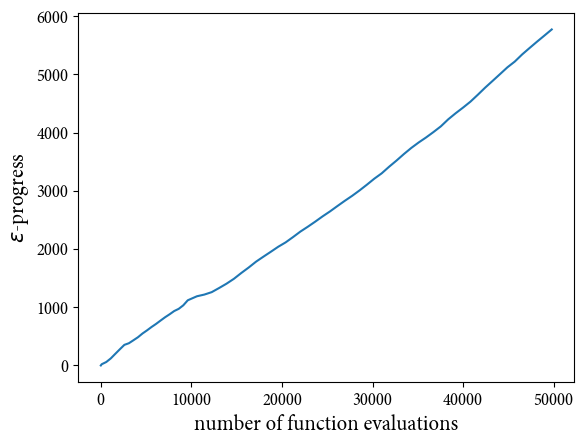

In [3]:
# Epsilon progress is already saved during the optimization
convergence = pd.read_csv("../outputs/baseline_convergence.csv")

fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations", fontsize=15)
ax.set_ylabel("$\epsilon$-progress", fontsize=15)
ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

## Hypervolume:

Let's find the best and worst possible results for all objectives (to normalize them within 0-1 interval) except Sudan's 90th percentile worst month (as it is always 0). I will determine the best and worst possible values for each objective among all the archivelogged sets as well as the final pareto-front:

In [4]:
obj_indexes = [-6,-5,-4,-3,-1] # To get rid of Sudan objectives
directions = ["min", "min", "min", "min", "max"] # Only GERD Hydropower is a maximization objective
best = [1e9,1e9,1e9,1e9,0] # Initialize the set of best values with really bad results (the aim is to reach the real best with the for loop)
worst = [0,0,0,0,1e10] # Same idea, initialize the worst as something very good

csvs_to_read = [f"../outputs/archive_logs/archive_{i}.csv" for i in range(2,70)]
csvs_to_read.append("../outputs/baseline_results.csv") # All archived solutions + final set

for file in csvs_to_read:
    current_df = pd.read_csv(file).iloc[:, obj_indexes]
    for i, col in enumerate(current_df.columns):
        # Updating the bests and worsts by looking at each solution:
        if directions[i] == "min":
            if current_df[col].max() > worst[i]: worst[i] = current_df[col].max()
            if current_df[col].min() < best[i]: best[i] = current_df[col].min()
        if directions[i] == "max":
            if current_df[col].max() > best[i]: best[i] = current_df[col].max()
            if current_df[col].min() < worst[i]: worst[i] = current_df[col].min()

In [5]:
print(best)
print(worst)

[1.5972156519361298, 0.1277789792337161, 0.0, 0.0, 9.232290012703256]
[8.930299988327855, 2.6255977813339806, 0.9083333333333332, 0.0927118710172617, 4.583104472793613]


In [6]:
# Normalize objectives function makes the best outcome 1, worst 0 for each obj value
def normalize_objs(df, worst, best):
    for i, col in enumerate(df.columns):
        df[col] = (best[i] - df[col]) / (best[i] - worst[i])
        
    return np.array(df)
            

In [7]:
from tqdm import tqdm
# Let's calculate hypervolume per NFE to plot
hvs = np.empty(0)
nfes = np.empty(0)
hv = get_performance_indicator("hv", ref_point=np.array([1.2, 1.2, 1.2, 1.2, 1.2])) # Reference set, works fine since everything is btwn 0-1

for i in tqdm(range(2,70)): # We have that 82 archive logs, first doesn't have a solution
    if i <= 20: nfes = np.append(nfes, 500*i) # Convergence check frequency is 500 NFEs
    else:
        if i > 20 and i <= 25:
            nfes = np.append(nfes, 10000 + (i-20) * (775.2))
        if i > 25:
            nfes = np.append(nfes, 13876 + (i-25) * (816))
        
    # print(i, "I am here NFE")
    hvs = np.append(hvs, (hv.do(normalize_objs( # Read and normalize data frames with 5 objectives
        pd.read_csv(f"../outputs/archive_logs/archive_{i}.csv").iloc[:, obj_indexes],
                                worst,
                                best
                               ))))
    # print(i, "I am here HV")

100%|██████████| 68/68 [01:41<00:00,  1.49s/it]


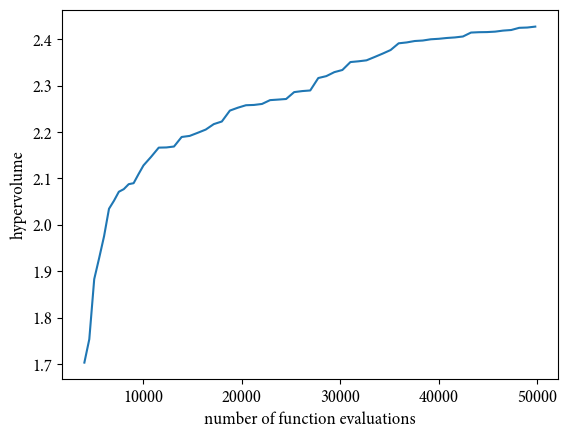

In [8]:
fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations")
ax.set_ylabel("hypervolume")
ax.plot(nfes[6:], hvs[6:]) # First 6 distorts the view, giving a wrong sense of convergence
plt.show()

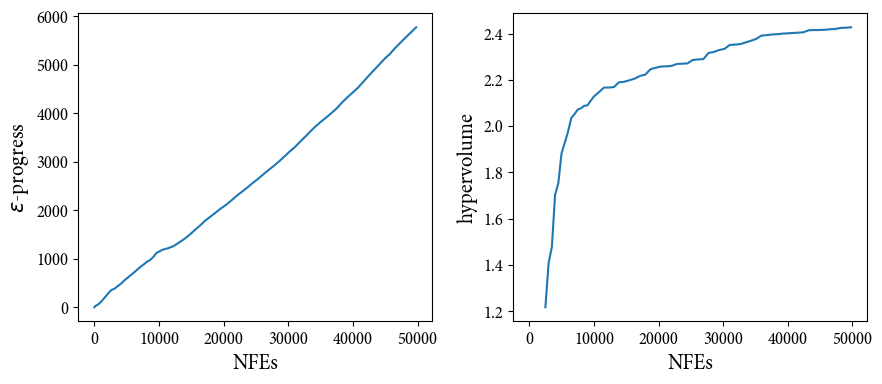

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(9, 4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel("$\epsilon$-progress", fontsize=15)
ax2.plot(nfes[3:], hvs[3:])
ax2.set_ylabel("hypervolume", fontsize=15)

ax1.set_xlabel("NFEs", fontsize=15)
ax2.set_xlabel("NFEs", fontsize=15)
fig.tight_layout()
#plt.grid(False)
plt.show()

Interestingly epsilon progress suggests there is room for improvement however hypervolume hints at the opposite with **50,000** NFEs!